## Redes Neurais Artificiais 2025.2

- **Disciplina**: Redes Neurais Artificiais 2025.2
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta segunda parte do Projeto Prático 2.2 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos

### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão. Para tanto, use o StandardScaler e inicialize-o com os dados do conjunto de treino (fit), ajudando-os em seguida (transform). Depois, ajuste os dados do conjunto de testes.

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.


### Continuando

5. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    5.1 Utilize a função de ativação ReLU  
    5.2 Utilize o solver Adam    
    5.3 Imprima o passo a passo do treinamento    
    5.4 Utilize o número máximo de épocas igual a 300  
6. Com o modelo em questão, após o treinamento, apresente:  
    6.1 Matriz de confusão para o conjunto de teste  
    6.2 Acurácia  
    6.3 F-Score  
    6.4 Precisão  
    6.5 Revocação  
7. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 10 vezes  
    7.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    7.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
8. Repita por 10 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    8.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Houve influência da escolha do otimizador no desempenho da rede?

In [86]:
# ==============================================================
# Libraries Import
# ==============================================================

import time
from math import sqrt
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.calibration import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from torch import Tensor, nn, optim


In [87]:
# ==============================================================
# Opening the Forest Cover Type dataset
# ==============================================================

"""
Answer to Question 1:
This cell loads the 'Forest Cover Type' dataset using pandas.
If the kagglehub package is available, it downloads the dataset directly.
Otherwise, it loads a local copy.
"""

try:
    path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")
    csv_path = Path(path, "covtype.csv")
    df = pd.read_csv(csv_path)
    print("Dataset successfully loaded from Kaggle.")
except Exception as e:
    print("Error using kagglehub:", e)
    df = pd.read_csv("covtype.csv")
    print("Dataset loaded from local file.")

print("Shape of the dataset:", df.shape)
df.head()

Dataset successfully loaded from Kaggle.
Shape of the dataset: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [88]:
# ==============================================================
# Removing categorical attributes
# ==============================================================

"""
Answer to Question 2:
This cell removes all categorical (binary dummy) columns from the dataset,
keeping only continuous (numerical) predictor attributes.
"""

# Identify categorical columns (Wilderness_Area and Soil_Type)
categorical_columns = [
    col for col in df.columns if "Wilderness_Area" in col or "Soil_Type" in col
]

# Remove them from the dataframe
df_numerical = df.drop(columns=categorical_columns)

print("Removed categorical columns:", len(categorical_columns))
print("Remaining columns:", df_numerical.shape[1])
df_numerical.head()

Removed categorical columns: 44
Remaining columns: 11


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,5
1,2590,56,2,212,-6,390,220,235,151,6225,5
2,2804,139,9,268,65,3180,234,238,135,6121,2
3,2785,155,18,242,118,3090,238,238,122,6211,2
4,2595,45,2,153,-1,391,220,234,150,6172,5


In [89]:
# ==============================================================
# Separating predictors (X) and target (y)
# ==============================================================

"""
Answer to Question 3:
This cell separates the target attribute (Cover_Type) into 'y'
and the remaining predictor attributes into 'X'.
"""

# Separate target and predictors
X = df_numerical.drop(columns=["Cover_Type"])
y = df_numerical["Cover_Type"]

print("Predictor matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)

Predictor matrix X shape: (581012, 10)
Target vector y shape: (581012,)


In [90]:
# ==============================================================
# Performing a holdout 70/30 partition
# ==============================================================

"""
Answer to Question 4:
This cell splits the dataset into training and testing subsets
using the holdout method with a 70/30 ratio.
"""


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (406708, 10)
Test set shape: (174304, 10)


In [91]:
# ==============================================================
# Scaling the attributes (Standardization)
# ==============================================================

"""
Answer to Question 5:
This cell performs standardization using sklearn's StandardScaler.
The scaler is fit only on the training set and then applied to both sets,
ensuring no data leakage from the test set.
"""

# Initialize and fit the scaler using training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply transformation to the test data
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed successfully.")
print("Scaled training data shape:", X_train_scaled.shape)
print("Scaled test data shape:", X_test_scaled.shape)

Feature scaling completed successfully.
Scaled training data shape: (406708, 10)
Scaled test data shape: (174304, 10)


In [92]:
# ==============================================================
# Training a MLP
# ==============================================================

"""
Answer to Question 5 (part 2 - MLP initial proposition):
This cell proposes a MLP model with the following parameters
 - Layers: input layer, 1 hidden layer, output layer
 - Hidden layer size: 10 neurons
And the following Hyperparameters:
 - Activation function: Relu
 - Solver: Adam
 - Max epochs: 300
"""

mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation="relu",
    solver="adam",
    max_iter=300,
    verbose=True,
)

mlp.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.85836226
Iteration 2, loss = 0.69767206
Iteration 3, loss = 0.68281398
Iteration 4, loss = 0.67694138
Iteration 5, loss = 0.67321842
Iteration 6, loss = 0.67041573
Iteration 7, loss = 0.66855277
Iteration 8, loss = 0.66728485
Iteration 9, loss = 0.66628405
Iteration 10, loss = 0.66535215
Iteration 11, loss = 0.66423195
Iteration 12, loss = 0.66335615
Iteration 13, loss = 0.66265721
Iteration 14, loss = 0.66220794
Iteration 15, loss = 0.66180672
Iteration 16, loss = 0.66149473
Iteration 17, loss = 0.66114343
Iteration 18, loss = 0.66087945
Iteration 19, loss = 0.66049392
Iteration 20, loss = 0.66018938
Iteration 21, loss = 0.65986359
Iteration 22, loss = 0.65942176
Iteration 23, loss = 0.65912609
Iteration 24, loss = 0.65883960
Iteration 25, loss = 0.65858066
Iteration 26, loss = 0.65814282
Iteration 27, loss = 0.65789382
Iteration 28, loss = 0.65768400
Iteration 29, loss = 0.65743255
Iteration 30, loss = 0.65719258
Iteration 31, loss = 0.65698050
Iteration 32, los

,hidden_layer_sizes,"(10,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,None


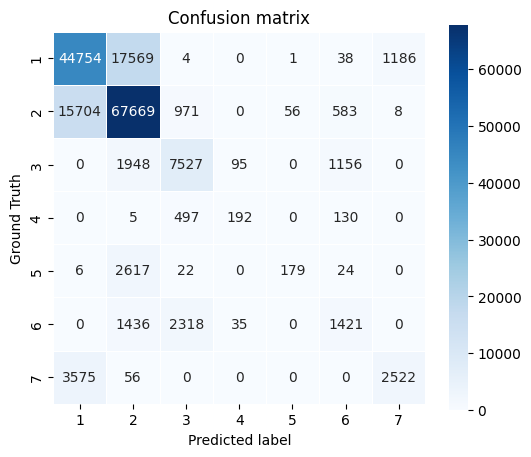


Métricas obtidas
 - Acurácia: 0.71
 - F1 Score: 0.70
 - Precisão: 0.71
 - Revocação: 0.71



In [93]:
# ==============================================================
# Evaluating the proposed model
# ==============================================================

"""
Answer to Question 6:
This cell will present the metrics obtained from the MLP proposed above.
Metrics used:
 - Accuracy
 - Precision
 - Recall
 - F1
 - Confusion matrix
"""

sorted_labels = np.sort(y.unique())

y_predict = mlp.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_predict, labels=sorted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidth=0.5,
    square=True,
    xticklabels=sorted_labels,  # pyright: ignore[reportArgumentType]
    yticklabels=sorted_labels, # pyright: ignore[reportArgumentType]
)

plt.xlabel("Predicted label")
plt.ylabel("Ground Truth")
plt.title("Confusion matrix")
plt.show()


# Métricas
acc = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average="weighted")
recall = recall_score(y_test, y_predict, average="weighted")
f1 = f1_score(y_test, y_predict, average="weighted")

print(f"""
Métricas obtidas
 - Acurácia: {acc:.2f}
 - F1 Score: {f1:.2f}
 - Precisão: {precision:.2f}
 - Revocação: {recall:.2f}
""")

In [94]:
def new_holdout_partitions():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [96]:
# ==============================================================
# Evaluating the proposed model
# ==============================================================

"""
Answer to Question 7:
This cell presents a more robust evaluation of the model, testing it 10 times.
Metrics used:
 - Accuracy
 - F1
"""


class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)


accuracy_list = []
f1_list = []

output_dim = len(y.unique())

for i in range(10):
    print(f"A iniciar a repetição {i + 1}/10...")
    X_train, X_test, y_train, y_test = new_holdout_partitions()

    X_train_t: Tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_t: Tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)  # Usa o mesmo mapeamento para o conjunto de teste

    y_train_t = torch.tensor(y_train_enc, dtype=torch.long).to(device)
    y_test_t_cpu = y_test_enc  # Mantemos uma cópia na CPU para a avaliação final

    input_dim: int = X_train_t.shape[1]
    hidden_dim = 10

    model: MLPModel = MLPModel(input_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_t)
        y_pred_t = torch.argmax(outputs, dim=1)
        y_pred = y_pred_t.cpu().numpy()

    acc = accuracy_score(y_test_t_cpu, y_pred)
    f1 = f1_score(y_test_t_cpu, y_pred, average="weighted")

    print(f"Modelo {i + 1}: acurácia {acc:.2f} - f1 score {f1:.2f}")

    accuracy_list.append(acc)
    f1_list.append(f1)

A iniciar a repetição 1/10...
Modelo 1: acurácia 0.62 - f1 score 0.59
A iniciar a repetição 2/10...
Modelo 2: acurácia 0.61 - f1 score 0.58
A iniciar a repetição 3/10...
Modelo 3: acurácia 0.59 - f1 score 0.54
A iniciar a repetição 4/10...
Modelo 4: acurácia 0.54 - f1 score 0.45
A iniciar a repetição 5/10...
Modelo 5: acurácia 0.61 - f1 score 0.58
A iniciar a repetição 6/10...
Modelo 6: acurácia 0.60 - f1 score 0.56
A iniciar a repetição 7/10...
Modelo 7: acurácia 0.58 - f1 score 0.53
A iniciar a repetição 8/10...
Modelo 8: acurácia 0.61 - f1 score 0.58
A iniciar a repetição 9/10...
Modelo 9: acurácia 0.60 - f1 score 0.57
A iniciar a repetição 10/10...
Modelo 10: acurácia 0.61 - f1 score 0.56


In [97]:
mean_acc = np.mean(accuracy_list)
std_acc = np.std(accuracy_list)
mean_f1 = np.mean(f1_list)
std_f1 = np.std(f1_list)

print(f"""
Média da acurácia: {mean_acc:.2f}
Desvio padrão da acurácia: {std_acc:.2f}

Média do F1 score: {mean_f1:.2f}
Desvio padrão do F1 score: {std_f1:.2f}
""")


Média da acurácia: 0.60
Desvio padrão da acurácia: 0.02

Média do F1 score: 0.55
Desvio padrão do F1 score: 0.04



### Question 9
Switching to a different optmizer, **sgd**, or **Stochastic gradient descent**, did not have a significant impact in the model's performance.
The standard deviation remained **0.00**, indicating high consistency. The mean accuracy was **0.72** with optimizer 'Adam' and **0.71** with optimizer 'sgd', while the meanF1 score showed a similar minimal variation. These results show that the overall model performance wasn't greatly affected by this choice.

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe alientar também que você efetuou o treinamento desta rede por 10 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros, repetindo cada treinamento/avaliação por 10 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

In [98]:
# classe para criar uma MLP dinâmica, com diferentes números de camadas e neurônios
class DynamicMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, activation_fn="relu"):
        super(DynamicMLPModel, self).__init__()

        layers = []

        if activation_fn == "relu":
            activation = nn.ReLU()
        elif activation_fn == "tanh":
            activation = nn.Tanh()
        else:
            activation = nn.ReLU()

        in_features = input_dim

        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(activation)
            in_features = hidden_units

        layers.append(nn.Linear(in_features, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [99]:
def evaluate_pytorch_mlp(hidden_layers, activation, solver, epochs):
    """
    Treina e avalia um modelo MLP em PyTorch por 10 repetições.

    Args:
        hidden_layers (tuple): Tupla com o número de neurônios em cada camada oculta.
        activation (str): 'relu' ou 'tanh'.
        solver (str): 'adam' ou 'sgd'.
        epochs (int): Número de épocas para o treino.

    Returns:
        tuple: (média_acurácia, desvio_padrão_acurácia, média_f1, desvio_padrão_f1)
    """
    accuracy_list = []
    f1_list = []
    input_dim = X.shape[1]
    output_dim = len(y.unique())

    for _ in range(10):
        X_train, X_test, y_train, y_test = new_holdout_partitions()

        X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)

        y_train_t = torch.tensor(y_train_enc, dtype=torch.long).to(device)

        model = DynamicMLPModel(input_dim, hidden_layers, output_dim, activation).to(
            device
        )

        criterion = nn.CrossEntropyLoss()

        if solver == "adam":
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        else:  # sgd
            optimizer = optim.SGD(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_t)
            loss = criterion(outputs, y_train_t)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            outputs = model(X_test_t)
            y_pred_t = torch.argmax(outputs, dim=1)
            y_pred = y_pred_t.cpu().numpy()

        acc = accuracy_score(y_test_enc, y_pred)
        f1 = f1_score(y_test_enc, y_pred, average="weighted")

        accuracy_list.append(acc)
        f1_list.append(f1)

    return (
        np.mean(accuracy_list),
        np.std(accuracy_list),
        np.mean(f1_list),
        np.std(f1_list),
    )

In [100]:
# 10 arquiteturas distintas
architectures = [
    {
        "id": "Modelo 1",
        "layers": (20,),
        "activation": "relu",
        "solver": "adam",
        "epochs": 150,
    },
    {
        "id": "Modelo 2",
        "layers": (10, 10),
        "activation": "relu",
        "solver": "adam",
        "epochs": 200,
    },
    {
        "id": "Modelo 3",
        "layers": (30, 15),
        "activation": "relu",
        "solver": "adam",
        "epochs": 200,
    },
    {
        "id": "Modelo 4",
        "layers": (20,),
        "activation": "tanh",
        "solver": "adam",
        "epochs": 150,
    },
    {
        "id": "Modelo 5",
        "layers": (10, 10),
        "activation": "tanh",
        "solver": "adam",
        "epochs": 200,
    },
    {
        "id": "Modelo 6",
        "layers": (50,),
        "activation": "relu",
        "solver": "sgd",
        "epochs": 200,
    },
    {
        "id": "Modelo 7",
        "layers": (25, 25),
        "activation": "relu",
        "solver": "sgd",
        "epochs": 200,
    },
    {
        "id": "Modelo 8",
        "layers": (20, 10),
        "activation": "tanh",
        "solver": "sgd",
        "epochs": 150,
    },
    {
        "id": "Modelo 9",
        "layers": (100,),
        "activation": "relu",
        "solver": "adam",
        "epochs": 100,
    },
    {
        "id": "Modelo 10",
        "layers": (5, 5),
        "activation": "relu",
        "solver": "adam",
        "epochs": 100,
    },
]

In [101]:
results_prop = {}

# avaliando cada arquitetura
for arch in architectures:
    print(f"Avaliando {arch['id']}...")
    mean_acc, std_acc, mean_f1, std_f1 = evaluate_pytorch_mlp(
        hidden_layers=arch["layers"],
        activation=arch["activation"],
        solver=arch["solver"],
        epochs=arch["epochs"],
    )
    results_prop[arch["id"]] = {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "mean_f1": mean_f1,
        "std_f1": std_f1,
        "config": f"{arch['layers']} | {arch['activation']} | {arch['solver']} | {arch['epochs']}",
    }

# resultados
df_results_prop = pd.DataFrame(results_prop).T
df_results_prop = df_results_prop.sort_values(by="mean_f1", ascending=False)

print("Resultados das Arquiteturas Propostas")
display(df_results_prop)

print("3 Melhores por F1-Score")
display(df_results_prop.head(3))

Avaliando Modelo 1...
Avaliando Modelo 2...
Avaliando Modelo 3...
Avaliando Modelo 4...
Avaliando Modelo 5...
Avaliando Modelo 6...
Avaliando Modelo 7...
Avaliando Modelo 8...
Avaliando Modelo 9...
Avaliando Modelo 10...
Resultados das Arquiteturas Propostas


,mean_acc,std_acc,mean_f1,std_f1,config
Modelo 3,0.669642,0.013353,0.638272,0.01363,"(30, 15) | relu | adam | 200"
Modelo 9,0.646178,0.007397,0.611778,0.007974,"(100,) | relu | adam | 100"
Modelo 4,0.632392,0.027762,0.59596,0.032156,"(20,) | tanh | adam | 150"
Modelo 5,0.641214,0.030753,0.595612,0.047651,"(10, 10) | tanh | adam | 200"
Modelo 2,0.584683,0.026543,0.536067,0.029173,"(10, 10) | relu | adam | 200"
Modelo 1,0.558932,0.033014,0.504739,0.042072,"(20,) | relu | adam | 150"
Modelo 6,0.362256,0.081264,0.352998,0.064774,"(50,) | relu | sgd | 200"
Modelo 10,0.333888,0.166652,0.265298,0.121846,"(5, 5) | relu | adam | 100"
Modelo 8,0.238999,0.143541,0.204455,0.115511,"(20, 10) | tanh | sgd | 150"
Modelo 7,0.255706,0.168022,0.171613,0.121361,"(25, 25) | relu | sgd | 200"


3 Melhores por F1-Score


,mean_acc,std_acc,mean_f1,std_f1,config
Modelo 3,0.669642,0.013353,0.638272,0.01363,"(30, 15) | relu | adam | 200"
Modelo 9,0.646178,0.007397,0.611778,0.007974,"(100,) | relu | adam | 100"
Modelo 4,0.632392,0.027762,0.59596,0.032156,"(20,) | tanh | adam | 150"


## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída. 

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_o$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

In [102]:
Ni: int = X.shape[1]
No: int = len(y.unique())

alpha_vals = [0.5, 2, 3]
neuron_counts = [int(alpha * sqrt(Ni * No)) for alpha in alpha_vals]
print(f"Número de neurônios calculados (Nh) para alpha={alpha_vals}: {neuron_counts}")

Número de neurônios calculados (Nh) para alpha=[0.5, 2, 3]: [4, 16, 25]


In [103]:
architectures_pyramid = []
model_id = 1
solvers: list[str] = ["adam", "sgd"]
activations: list[str] = ["relu", "tanh"]
epochs_list: list[int] = [100, 150, 200]
n1, n2, n3 = neuron_counts[0], neuron_counts[1], neuron_counts[2]

In [104]:
architectures_pyramid = []
model_id = 1
solvers: list[str] = ["adam", "sgd"]
activations: list[str] = ["relu", "tanh"]
epochs_list: list[int] = [100, 150, 200]
n1, n2, n3 = neuron_counts[0], neuron_counts[1], neuron_counts[2]

# camadas únicas 3 * 2 * 2 = 12 modelos
for n in neuron_counts:
    for solver in solvers:
        architectures_pyramid.append(
            {
                "id": f"Modelo P{model_id}",
                "layers": (n,),
                "activation": "relu",
                "solver": solver,
                "epochs": 150,
            }
        )
        model_id += 1
        architectures_pyramid.append(
            {
                "id": f"Modelo P{model_id}",
                "layers": (n,),
                "activation": "tanh",
                "solver": solver,
                "epochs": 150,
            }
        )
        model_id += 1

# camadas duplas 2 * 3 * 2 = 12 modelos
for n_in in [n1, n2]:
    for n_out in [n1, n2, n3]:
        architectures_pyramid.append(
            {
                "id": f"Modelo P{model_id}",
                "layers": (n_in, n_out),
                "activation": "relu",
                "solver": "adam",
                "epochs": 200,
            }
        )
        model_id += 1
        architectures_pyramid.append(
            {
                "id": f"Modelo P{model_id}",
                "layers": (n_in, n_out),
                "activation": "relu",
                "solver": "sgd",
                "epochs": 200,
            }
        )
        model_id += 1

# restantes aleatorios
architectures_pyramid.append(
    {
        "id": f"Modelo P{model_id}",
        "layers": (n3, n1),
        "activation": "relu",
        "solver": "adam",
        "epochs": 100,
    }
)
model_id += 1
architectures_pyramid.append(
    {
        "id": f"Modelo P{model_id}",
        "layers": (n3, n2),
        "activation": "tanh",
        "solver": "adam",
        "epochs": 150,
    }
)
model_id += 1
architectures_pyramid.append(
    {
        "id": f"Modelo P{model_id}",
        "layers": (n3, n3),
        "activation": "relu",
        "solver": "adam",
        "epochs": 200,
    }
)
model_id += 1
architectures_pyramid.append(
    {
        "id": f"Modelo P{model_id}",
        "layers": (n1, n3),
        "activation": "tanh",
        "solver": "sgd",
        "epochs": 100,
    }
)
model_id += 1
architectures_pyramid.append(
    {
        "id": f"Modelo P{model_id}",
        "layers": (n2, n1),
        "activation": "tanh",
        "solver": "sgd",
        "epochs": 150,
    }
)
model_id += 1
architectures_pyramid.append(
    {
        "id": f"Modelo P{model_id}",
        "layers": (n1, n2),
        "activation": "relu",
        "solver": "adam",
        "epochs": 100,
    }
)
model_id += 1

print(
    f"Lista com {len(architectures_pyramid)} modelos criada com sucesso"
)

Lista com 30 modelos criada com sucesso


In [105]:
# avaliando cada arquitetura
results_pyramid = {}
for arch in architectures_pyramid:
    print(f"Avaliando {arch['id']}...")
    mean_acc, std_acc, mean_f1, std_f1 = evaluate_pytorch_mlp(
        hidden_layers=arch["layers"],
        activation=arch["activation"],
        solver=arch["solver"],
        epochs=arch["epochs"],
    )
    results_pyramid[arch["id"]] = {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "mean_f1": mean_f1,
        "std_f1": std_f1,
        "config": f"{arch['layers']} | {arch['activation']} | {arch['solver']} | {arch['epochs']}",
    }

# resultados vão ser exibidos após todas as execuções
df_results_pyramid = pd.DataFrame(results_pyramid).T
df_results_pyramid: pd.DataFrame = df_results_pyramid.sort_values(
    by="mean_f1", ascending=False
)

print("Resultados da Regra da Pirâmide Geométrica")
display(df_results_pyramid)

print("3 Melhores por F1-Score")
display(df_results_pyramid.head(3))

Avaliando Modelo P1...
Avaliando Modelo P2...
Avaliando Modelo P3...
Avaliando Modelo P4...
Avaliando Modelo P5...
Avaliando Modelo P6...
Avaliando Modelo P7...
Avaliando Modelo P8...
Avaliando Modelo P9...
Avaliando Modelo P10...
Avaliando Modelo P11...
Avaliando Modelo P12...
Avaliando Modelo P13...
Avaliando Modelo P14...
Avaliando Modelo P15...
Avaliando Modelo P16...
Avaliando Modelo P17...
Avaliando Modelo P18...
Avaliando Modelo P19...
Avaliando Modelo P20...
Avaliando Modelo P21...
Avaliando Modelo P22...
Avaliando Modelo P23...
Avaliando Modelo P24...
Avaliando Modelo P25...
Avaliando Modelo P26...
Avaliando Modelo P27...
Avaliando Modelo P28...
Avaliando Modelo P29...
Avaliando Modelo P30...
Resultados da Regra da Pirâmide Geométrica


,mean_acc,std_acc,mean_f1,std_f1,config
Modelo P27,0.68334,0.003006,0.652018,0.00329,"(25, 25) | relu | adam | 200"
Modelo P26,0.683202,0.004245,0.651078,0.004878,"(25, 16) | tanh | adam | 150"
Modelo P10,0.654346,0.013306,0.622297,0.013111,"(25,) | tanh | adam | 150"
Modelo P23,0.649533,0.013402,0.611009,0.020936,"(16, 25) | relu | adam | 200"
Modelo P21,0.639211,0.021441,0.603678,0.028148,"(16, 16) | relu | adam | 200"
Modelo P6,0.615943,0.025796,0.578571,0.037143,"(16,) | tanh | adam | 150"
Modelo P9,0.569744,0.028753,0.520007,0.048493,"(25,) | relu | adam | 150"
Modelo P17,0.558847,0.02965,0.504076,0.054224,"(4, 25) | relu | adam | 200"
Modelo P19,0.550961,0.053054,0.472091,0.083361,"(16, 4) | relu | adam | 200"
Modelo P5,0.531766,0.036267,0.463949,0.055711,"(16,) | relu | adam | 150"


3 Melhores por F1-Score


,mean_acc,std_acc,mean_f1,std_f1,config
Modelo P27,0.68334,0.003006,0.652018,0.00329,"(25, 25) | relu | adam | 200"
Modelo P26,0.683202,0.004245,0.651078,0.004878,"(25, 16) | tanh | adam | 150"
Modelo P10,0.654346,0.013306,0.622297,0.013111,"(25,) | tanh | adam | 150"


## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante 10 repetições de cada (aferir flutuação estocástica)

In [106]:
top_3_prop: pd.DataFrame = df_results_prop.head(3)
top_3_pyramid: pd.DataFrame = df_results_pyramid.head(3)

# combinando os dois df em um
top_6_df: pd.DataFrame = pd.concat([top_3_prop, top_3_pyramid])
print("6 melhores modelos:")
display(top_6_df)


top_6_models = []

for index, row in top_3_prop.iterrows():
    config_str = row["config"]
    layers_str, activation, solver, epochs_str = [
        s.strip() for s in config_str.split("|")
    ]

    layers = eval(layers_str)  # eval() converte a string '(30, 15)' para um tuplo
    epochs = int(epochs_str)

    top_6_models.append(
        {
            "id": f"próprio - {index}",
            "layers": layers,
            "activation": activation,
            "solver": solver,
        }
    )

for index, row in top_3_pyramid.iterrows():
    config_str = row["config"]
    layers_str, activation, solver, epochs_str = [
        s.strip() for s in config_str.split("|")
    ]

    layers = eval(layers_str)
    epochs = int(epochs_str)

    top_6_models.append(
        {
            "id": f"pirâmide - {index}",
            "layers": layers,
            "activation": activation,
            "solver": solver,
        }
    )

6 melhores modelos:


,mean_acc,std_acc,mean_f1,std_f1,config
Modelo 3,0.669642,0.013353,0.638272,0.01363,"(30, 15) | relu | adam | 200"
Modelo 9,0.646178,0.007397,0.611778,0.007974,"(100,) | relu | adam | 100"
Modelo 4,0.632392,0.027762,0.59596,0.032156,"(20,) | tanh | adam | 150"
Modelo P27,0.68334,0.003006,0.652018,0.00329,"(25, 25) | relu | adam | 200"
Modelo P26,0.683202,0.004245,0.651078,0.004878,"(25, 16) | tanh | adam | 150"
Modelo P10,0.654346,0.013306,0.622297,0.013111,"(25,) | tanh | adam | 150"


In [107]:
def new_holdout_partitions_full():
    X_full = df.drop(columns=["Cover_Type"])
    y_full = df["Cover_Type"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=0.3, stratify=y_full
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [108]:
N_REPETICOES = 100
EPOCHS = 200

final_results = {}
f1_scores_boxplot = {}

input_dim_full: int = df.shape[1] - 1
output_dim_full: int = len(df["Cover_Type"].unique())

for model_config in top_6_models:
    model_id = model_config["id"]
    start_time = time.time()

    print(f"avaliando o modelo '{model_id}' por {N_REPETICOES} repetições")

    accuracy_list = []
    f1_list = []

    for i in range(N_REPETICOES):
        X_train, X_test, y_train, y_test = new_holdout_partitions_full()

        X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)
        y_train_t = torch.tensor(y_train_enc, dtype=torch.long).to(device)

        model = DynamicMLPModel(
            input_dim=input_dim_full,
            hidden_layers=model_config["layers"],
            output_dim=output_dim_full,
            activation_fn=model_config["activation"],
        ).to(device)

        criterion = nn.CrossEntropyLoss()

        if model_config["solver"] == "adam":
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        else:  # sgd
            optimizer = optim.SGD(model.parameters(), lr=0.001)

        for epoch in range(EPOCHS):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_t)
            loss = criterion(outputs, y_train_t)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            outputs = model(X_test_t)
            y_pred_t = torch.argmax(outputs, dim=1)
            y_pred = y_pred_t.cpu().numpy()

        acc = accuracy_score(y_test_enc, y_pred)
        f1 = f1_score(y_test_enc, y_pred, average="weighted")

        accuracy_list.append(acc)
        f1_list.append(f1)

        if i < 10:
            if model_id not in f1_scores_boxplot:
                f1_scores_boxplot[model_id] = []
            f1_scores_boxplot[model_id].append(f1)

    end_time: float = time.time()

    final_results[model_id] = {
        "Média Acurácia": np.mean(accuracy_list),
        "DP Acurácia": np.std(accuracy_list),
        "Média F1-Score": np.mean(f1_list),
        "DP F1-Score": np.std(f1_list),
        "Tempo (s)": end_time - start_time,
    }

avaliando o modelo 'próprio - Modelo 3' por 100 repetições
avaliando o modelo 'próprio - Modelo 9' por 100 repetições
avaliando o modelo 'próprio - Modelo 4' por 100 repetições
avaliando o modelo 'pirâmide - Modelo P27' por 100 repetições
avaliando o modelo 'pirâmide - Modelo P26' por 100 repetições
avaliando o modelo 'pirâmide - Modelo P10' por 100 repetições


\Resultados Finais (com Atributos Categóricos) ---


,Média Acurácia,DP Acurácia,Média F1-Score,DP F1-Score,Tempo (s)
próprio - Modelo 9,0.723954,0.002070,0.706756,0.002307,798.562893
pirâmide - Modelo P26,0.711264,0.005233,0.688965,0.007027,478.723695
pirâmide - Modelo P27,0.709007,0.006791,0.684698,0.010409,547.626080
próprio - Modelo 3,0.704503,0.006893,0.677889,0.009924,503.480486
pirâmide - Modelo P10,0.693355,0.004712,0.673579,0.005170,370.825850
próprio - Modelo 4,0.683805,0.005471,0.662435,0.006647,328.086822


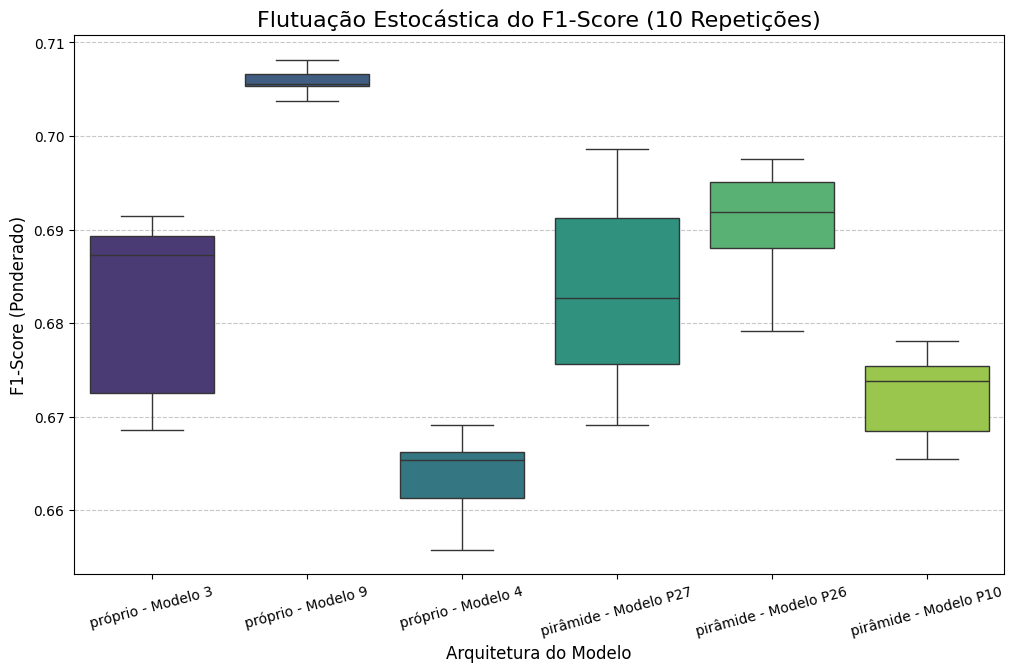

In [ ]:
df_final = pd.DataFrame(final_results).T
df_final: pd.DataFrame = df_final.sort_values(by="Média F1-Score", ascending=False)

print("\\Resultados Finais (com Atributos Categóricos)")
display(df_final)

df_boxplot = pd.DataFrame(f1_scores_boxplot)
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_boxplot, palette="viridis")
plt.title("Flutuação Estocástica do F1-Score (10 Repetições)", fontsize=16)
plt.ylabel("F1-Score (Ponderado)", fontsize=12)
plt.xlabel("Arquitetura do Modelo", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?

1 - Sim, o modelo 9 usando estratégia própria se mostrou melhor que os demais.

2 - A estratégia de Pirâmide Geométrica produziu 3 redes com métricas próximas, se mostrando mais consistente que a estratégia própria, mesmo não produzindo a melhor rede.

3 - Sim, a adição dos atributos categóricos aumentou a acurácia e f1-score das redes.

4 - Não, inclusive a rede que se saiu melhor foi treinada com 100 épocas.

5 - A maior dificuldade foi quanto a otimização no tempo de treinamento, tivemos que utilizar a biblioteca Pytorch com aceleração de gpu via CUDA para que a atividade fosse feita em tempo hábil.